In [ ]:
!pip install torch==1.4.0 \
torchvision==0.5.0 -f https://download.pytorch.org/whl/cu101/torch_stable.html

In [ ]:
!pip install torch-geometric \
  torch-sparse==latest+cu101 \
  torch-scatter==latest+cu101 \
  torch-cluster==latest+cu101 \
  -f https://pytorch-geometric.com/whl/torch-1.4.0.html

In [3]:
# Defining a GCN layer

import torch
import torch.nn as nn
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConvLayer(MessagePassing):
  def __init__(self, in_channels, out_channels):
    super(GCNConvLayer, self).__init__(aggr = 'add')
    self.linear = nn.Linear(in_channels, out_channels)

  def forward(self, x, edge_index):
    # Self loops are added
    edge_index, _ = add_self_loops(edge_index,
                                   num_nodes = x.size(0))  
    # Weight multiplication
    x = self.linear(x)

    # Normalisation according to GCN principle
    row, column = edge_index
    degree_ = degree(row, 
                     x.size(0),
                     dtype = x.dtype)
    inv = degree_.pow(-0.5)
    norm = inv[row] * inv[column]

    # Propagate embeddings to the next layer
    return self.propagate(edge_index,
                          size = (x.size(0), x.size(0)),
                          x = x,
                          norm = norm)
    
  def message(self, x_j, norm):

    # Normalisation of the node features
    val = norm.view(-1, 1) * x_j
    return val  

In [15]:
import torch
import torch.nn.functional as F

class Net(nn.Module):
  def __init__(self, dataset):
    super(Net, self).__init__()
    self.conv1 = GCNConvLayer(dataset.num_node_features,
                              16)
    self.conv2 = GCNConvLayer(16,
                              dataset.num_classes)
    
  def forward(self, data):
    x = data.x
    edge_index = data.edge_index

    x = self.conv1(x, edge_index)
    x = F.relu(x)
    x = F.dropout(x,
                  training = self.training)
    x = self.conv2(x, edge_index)

    return F.log_softmax(x,
                         dim = 1)  

## Cora Dataset

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from torch_geometric.datasets import Planetoid

In [22]:
def test(data,
         model, 
         train = True):
  
  model.eval();
  correct = 0
  
  prediction = model(data).max(dim = 1)[1]
  if train:
    correct += prediction[data.train_mask].eq(data.y[data.train_mask]).sum().item()
    return correct / len(data.y[data.train_mask])

  else:
    correct += prediction[data.test_mask].eq(data.y[data.test_mask]).sum().item()
    return correct / len(data.y[data.test_mask])  

In [27]:
def train(data, model, optimizer, plot = False):
  train_acc = []
  test_acc = []

  num_epochs = 100
  for epoch in range(num_epochs):
    model.train();
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask],
                      data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    train_accuracy = test(data, model)
    test_accuracy = test(data, model, train = False)

    train_acc.append(train_accuracy)
    test_acc.append(test_accuracy)

    print('Epoch : {:03d}, Loss : {:.5f}, Train Accuracy : {:.5f}, Test Accuracy : {:.5f}'.
          format(epoch, loss, train_accuracy, test_accuracy))
    
    if plot:
      plt.plot(train_acc, label = "Train Accuracy")
      plt.plot(test_acc, label = "Test Accuracy")
      plt.xlabel("Epoch")
      plt.ylabel("Accuracy")
      plt.legend(loc = "upper right")
      plt.show()

In [28]:
def plot_dataset(dataset):
  edges_raw = dataset.data.edge_index.numpy()
  edges = [(x, y) for x, y in zip(edges_raw[0, :],
                                  edges_raw[1, :])]
  labels = dataset.data.y.numpy()

  # NetworkX object ---
  Gx = nx.Graph()
  Gx.add_nodes_from(list(
      range(np.max(edges_raw))
  ))   
  Gx.add_edges_from(edges)
  plt.subplot(111)
  opts = {
      'node_size': 35,
      'width': 0.18
  }                

  nx.draw(Gx, with_labels = False,
          node_color = labels.tolist(),
          cmap = plt.cm.tab10,
          font_weight = 'bold',
          **opts)
  
  plt.show()            

In [29]:
def main():
    dataset = Planetoid(root='/content/Cora', name='Cora')
    plot_dataset(dataset)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = Net(dataset).to(device)
    data = dataset[0].to(device)
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=0.01, 
                                 weight_decay=5e-4)

    train(data, model, optimizer, plot=True)

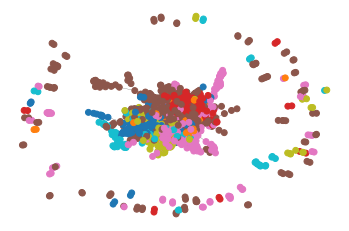

Epoch : 000, Loss : 1.94997, Train Accuracy : 0.17143, Test Accuracy : 0.14700


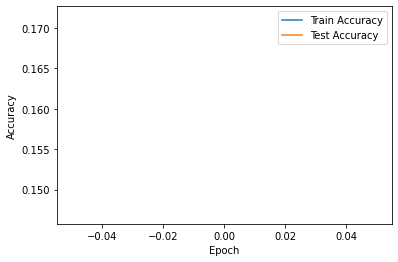

Epoch : 001, Loss : 1.91210, Train Accuracy : 0.37143, Test Accuracy : 0.26600


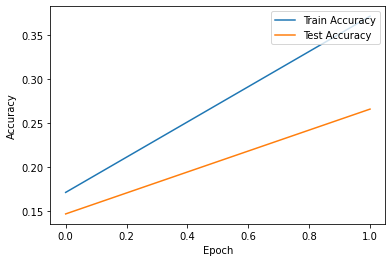

Epoch : 002, Loss : 1.84765, Train Accuracy : 0.54286, Test Accuracy : 0.32700


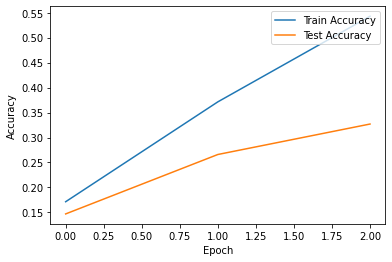

Epoch : 003, Loss : 1.77632, Train Accuracy : 0.67857, Test Accuracy : 0.37900


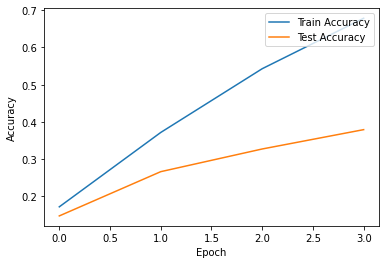

Epoch : 004, Loss : 1.68293, Train Accuracy : 0.67143, Test Accuracy : 0.35100


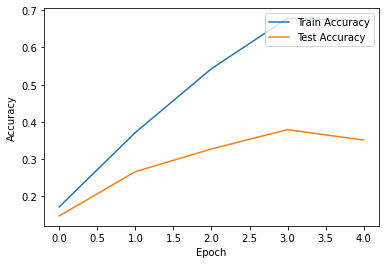

Epoch : 005, Loss : 1.59431, Train Accuracy : 0.65714, Test Accuracy : 0.35100


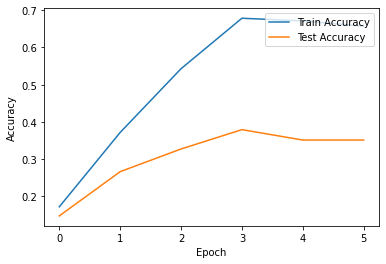

Epoch : 006, Loss : 1.52198, Train Accuracy : 0.70000, Test Accuracy : 0.40700


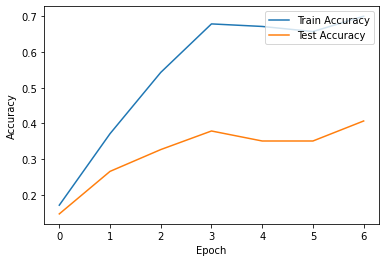

Epoch : 007, Loss : 1.43447, Train Accuracy : 0.79286, Test Accuracy : 0.49000


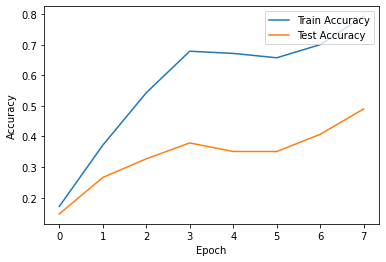

Epoch : 008, Loss : 1.32296, Train Accuracy : 0.87857, Test Accuracy : 0.58600


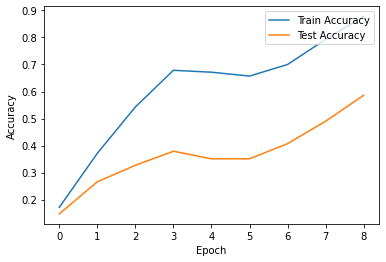

Epoch : 009, Loss : 1.25569, Train Accuracy : 0.92143, Test Accuracy : 0.66800


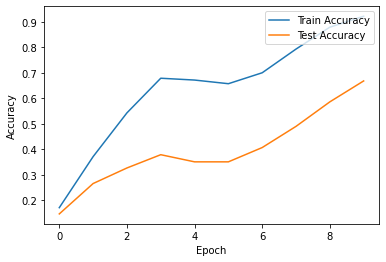

Epoch : 010, Loss : 1.12254, Train Accuracy : 0.92143, Test Accuracy : 0.70700


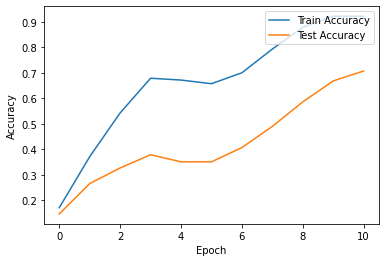

Epoch : 011, Loss : 1.04751, Train Accuracy : 0.92857, Test Accuracy : 0.73600


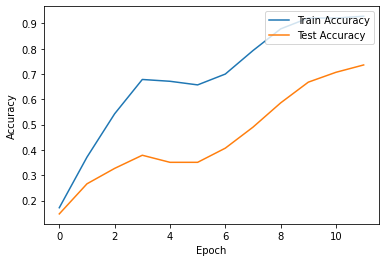

Epoch : 012, Loss : 0.95836, Train Accuracy : 0.93571, Test Accuracy : 0.75300


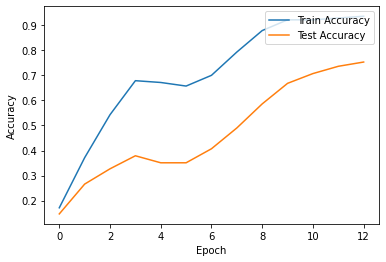

Epoch : 013, Loss : 0.89272, Train Accuracy : 0.94286, Test Accuracy : 0.77000


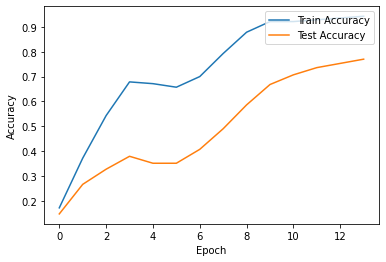

Epoch : 014, Loss : 0.77756, Train Accuracy : 0.95000, Test Accuracy : 0.78400


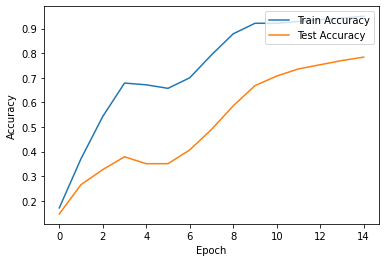

Epoch : 015, Loss : 0.72873, Train Accuracy : 0.96429, Test Accuracy : 0.80100


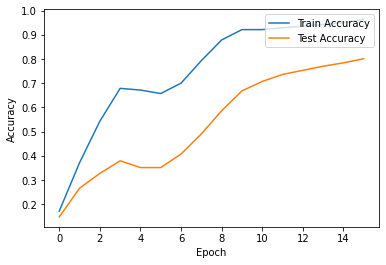

Epoch : 016, Loss : 0.63896, Train Accuracy : 0.97857, Test Accuracy : 0.80400


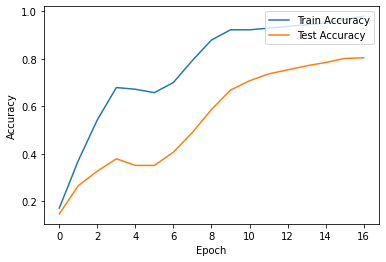

Epoch : 017, Loss : 0.56875, Train Accuracy : 0.97857, Test Accuracy : 0.80600


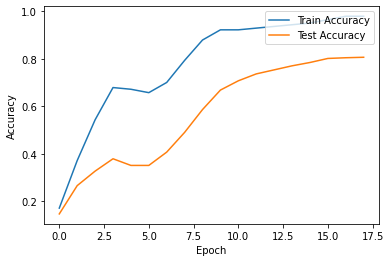

Epoch : 018, Loss : 0.49271, Train Accuracy : 0.98571, Test Accuracy : 0.80300


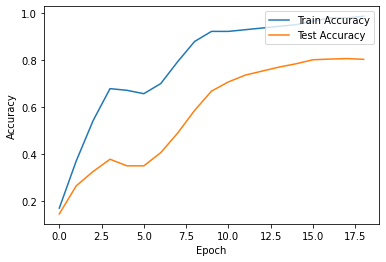

Epoch : 019, Loss : 0.48510, Train Accuracy : 0.98571, Test Accuracy : 0.80100


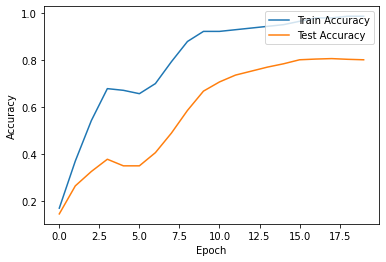

Epoch : 020, Loss : 0.41352, Train Accuracy : 0.98571, Test Accuracy : 0.80100


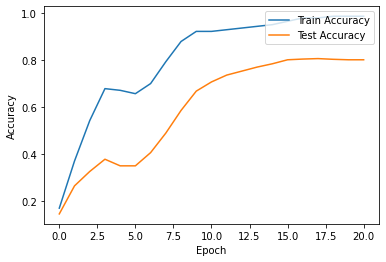

Epoch : 021, Loss : 0.36719, Train Accuracy : 0.99286, Test Accuracy : 0.80200


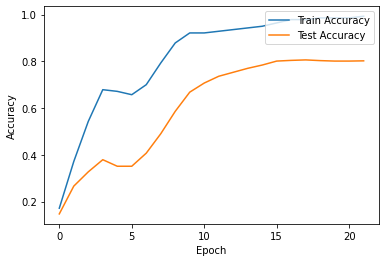

Epoch : 022, Loss : 0.32479, Train Accuracy : 0.99286, Test Accuracy : 0.80400


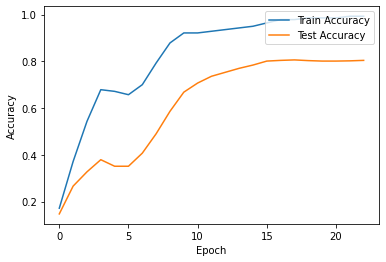

Epoch : 023, Loss : 0.28321, Train Accuracy : 0.99286, Test Accuracy : 0.80400


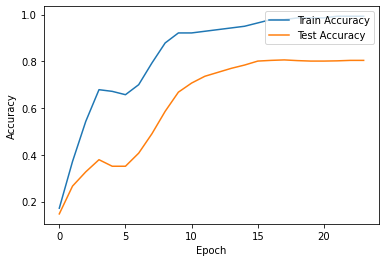

Epoch : 024, Loss : 0.27150, Train Accuracy : 0.99286, Test Accuracy : 0.80500


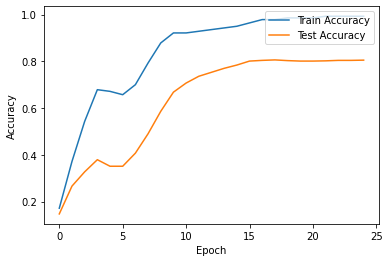

Epoch : 025, Loss : 0.25508, Train Accuracy : 0.99286, Test Accuracy : 0.80900


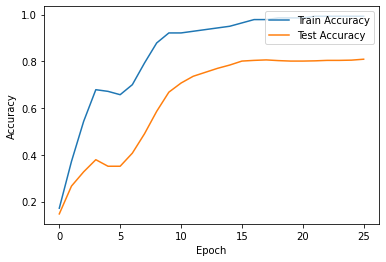

Epoch : 026, Loss : 0.20695, Train Accuracy : 1.00000, Test Accuracy : 0.81100


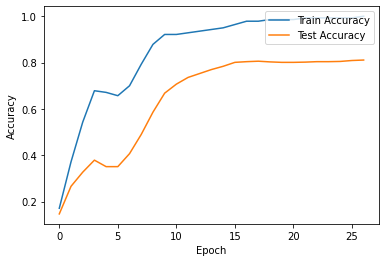

Epoch : 027, Loss : 0.19407, Train Accuracy : 1.00000, Test Accuracy : 0.80900


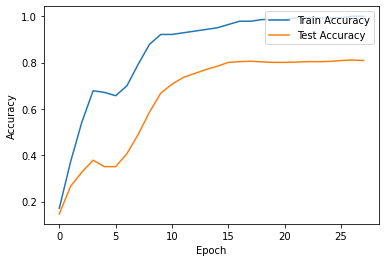

Epoch : 028, Loss : 0.18799, Train Accuracy : 1.00000, Test Accuracy : 0.80400


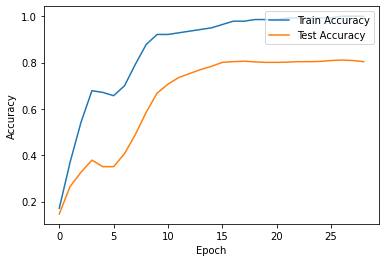

Epoch : 029, Loss : 0.17176, Train Accuracy : 1.00000, Test Accuracy : 0.80200


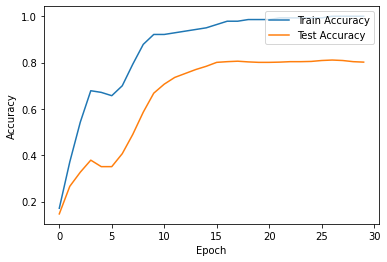

Epoch : 030, Loss : 0.17821, Train Accuracy : 1.00000, Test Accuracy : 0.80300


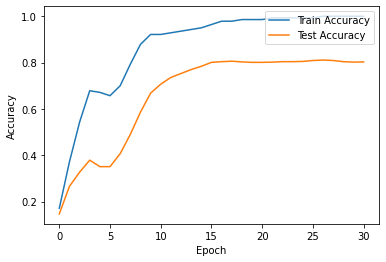

Epoch : 031, Loss : 0.14640, Train Accuracy : 1.00000, Test Accuracy : 0.80100


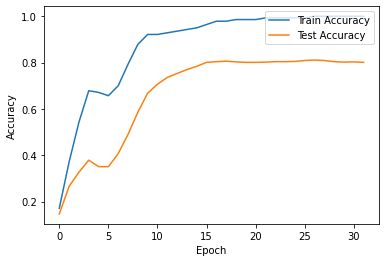

Epoch : 032, Loss : 0.15597, Train Accuracy : 1.00000, Test Accuracy : 0.80200


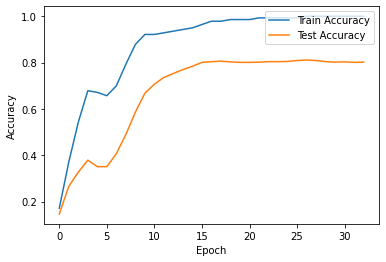

Epoch : 033, Loss : 0.13234, Train Accuracy : 1.00000, Test Accuracy : 0.79900


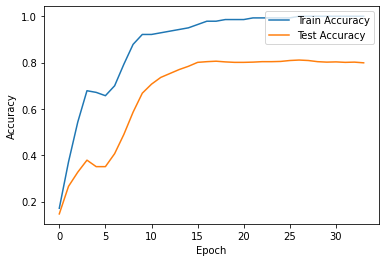

Epoch : 034, Loss : 0.12689, Train Accuracy : 1.00000, Test Accuracy : 0.80100


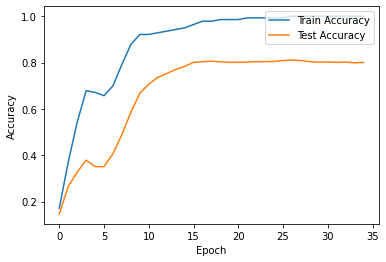

Epoch : 035, Loss : 0.07932, Train Accuracy : 1.00000, Test Accuracy : 0.79700


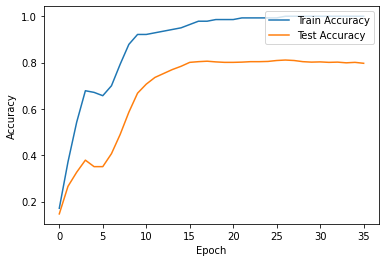

Epoch : 036, Loss : 0.07514, Train Accuracy : 1.00000, Test Accuracy : 0.79500


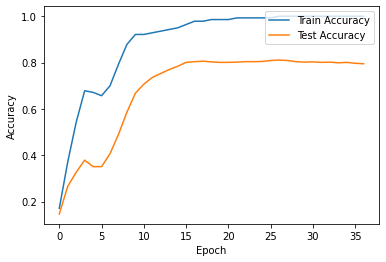

Epoch : 037, Loss : 0.11312, Train Accuracy : 1.00000, Test Accuracy : 0.79400


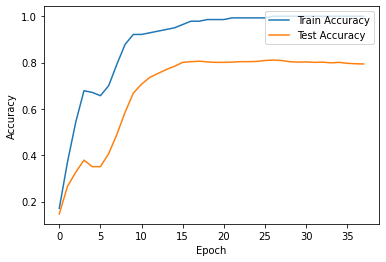

Epoch : 038, Loss : 0.09780, Train Accuracy : 1.00000, Test Accuracy : 0.79200


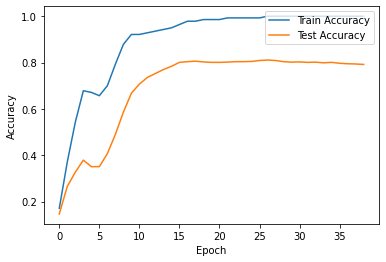

Epoch : 039, Loss : 0.08117, Train Accuracy : 1.00000, Test Accuracy : 0.78900


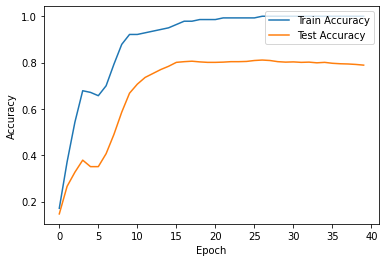

Epoch : 040, Loss : 0.07807, Train Accuracy : 1.00000, Test Accuracy : 0.78700


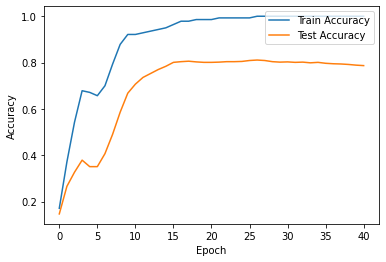

Epoch : 041, Loss : 0.05391, Train Accuracy : 1.00000, Test Accuracy : 0.78400


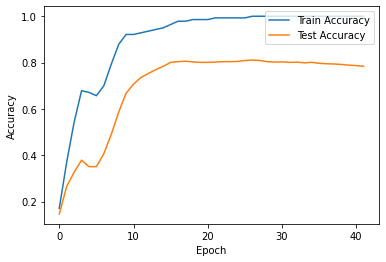

Epoch : 042, Loss : 0.06710, Train Accuracy : 1.00000, Test Accuracy : 0.78500


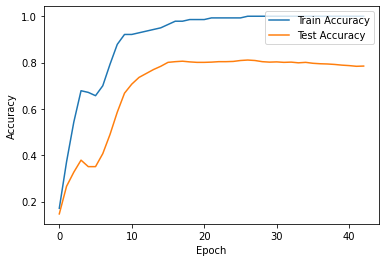

Epoch : 043, Loss : 0.08037, Train Accuracy : 1.00000, Test Accuracy : 0.78600


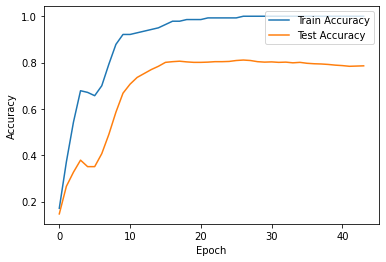

Epoch : 044, Loss : 0.05770, Train Accuracy : 1.00000, Test Accuracy : 0.79000


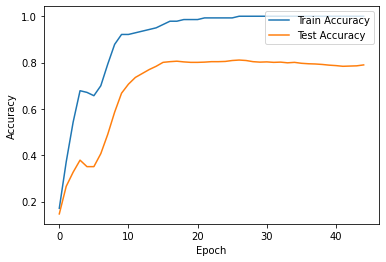

Epoch : 045, Loss : 0.07419, Train Accuracy : 1.00000, Test Accuracy : 0.79000


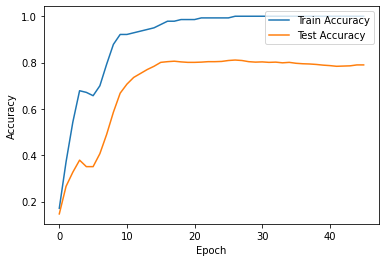

Epoch : 046, Loss : 0.05976, Train Accuracy : 1.00000, Test Accuracy : 0.79400


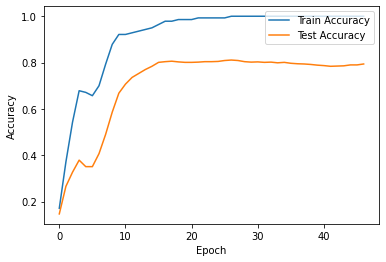

Epoch : 047, Loss : 0.05654, Train Accuracy : 1.00000, Test Accuracy : 0.79200


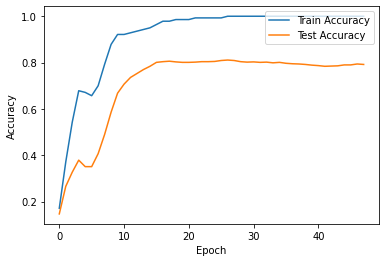

Epoch : 048, Loss : 0.05904, Train Accuracy : 1.00000, Test Accuracy : 0.79100


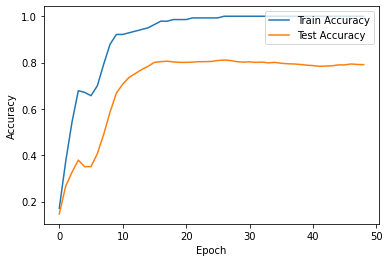

Epoch : 049, Loss : 0.04635, Train Accuracy : 1.00000, Test Accuracy : 0.79400


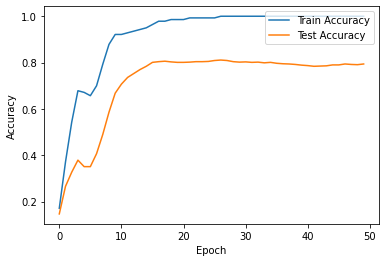

Epoch : 050, Loss : 0.05699, Train Accuracy : 1.00000, Test Accuracy : 0.79400


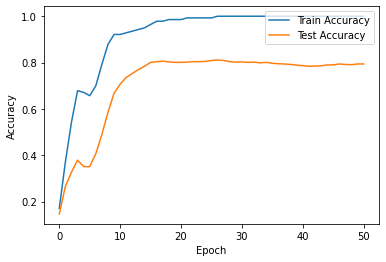

Epoch : 051, Loss : 0.06287, Train Accuracy : 1.00000, Test Accuracy : 0.79500


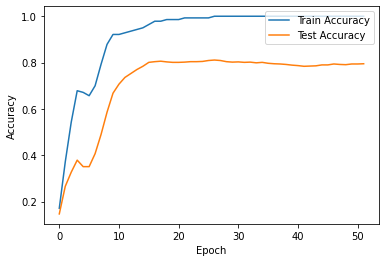

Epoch : 052, Loss : 0.07863, Train Accuracy : 1.00000, Test Accuracy : 0.79700


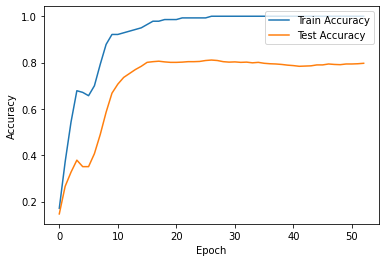

Epoch : 053, Loss : 0.06053, Train Accuracy : 1.00000, Test Accuracy : 0.79400


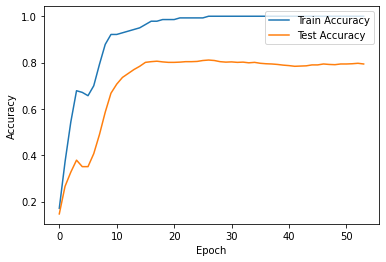

Epoch : 054, Loss : 0.04704, Train Accuracy : 1.00000, Test Accuracy : 0.79300


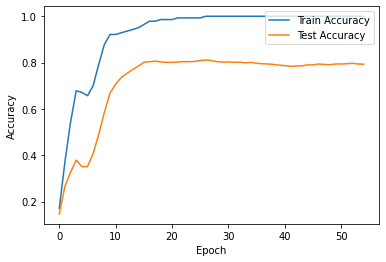

Epoch : 055, Loss : 0.03174, Train Accuracy : 1.00000, Test Accuracy : 0.79200


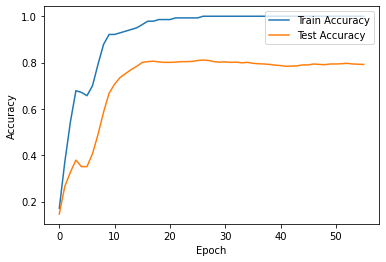

Epoch : 056, Loss : 0.04847, Train Accuracy : 1.00000, Test Accuracy : 0.79100


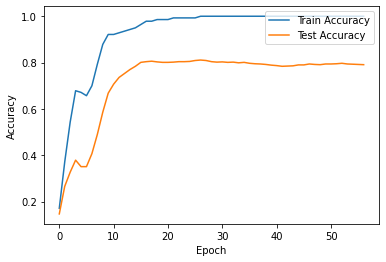

Epoch : 057, Loss : 0.05319, Train Accuracy : 1.00000, Test Accuracy : 0.79100


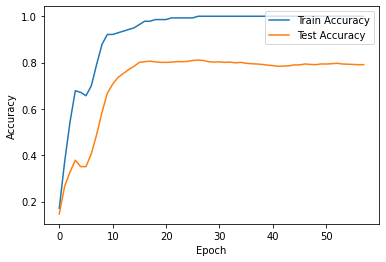

Epoch : 058, Loss : 0.06404, Train Accuracy : 1.00000, Test Accuracy : 0.79300


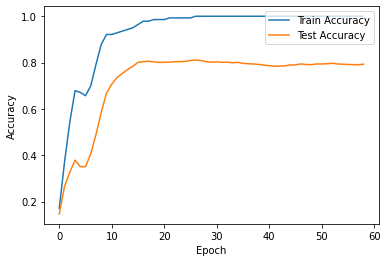

Epoch : 059, Loss : 0.05322, Train Accuracy : 1.00000, Test Accuracy : 0.79300


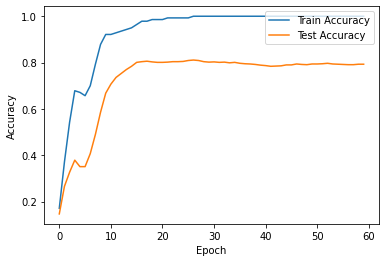

Epoch : 060, Loss : 0.09359, Train Accuracy : 1.00000, Test Accuracy : 0.78900


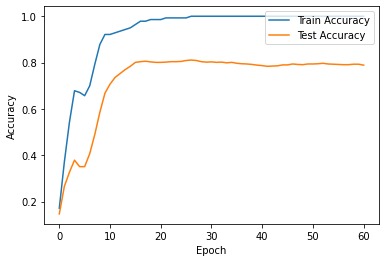

Epoch : 061, Loss : 0.04922, Train Accuracy : 1.00000, Test Accuracy : 0.78800


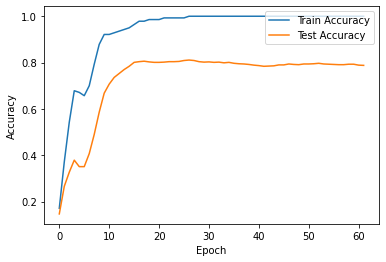

Epoch : 062, Loss : 0.04994, Train Accuracy : 1.00000, Test Accuracy : 0.78700


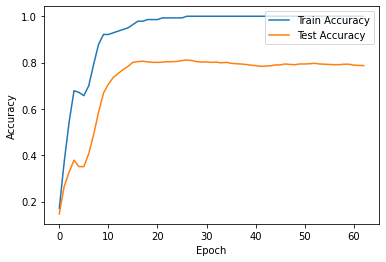

Epoch : 063, Loss : 0.05063, Train Accuracy : 1.00000, Test Accuracy : 0.78800


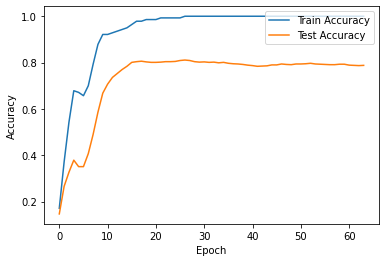

Epoch : 064, Loss : 0.03814, Train Accuracy : 1.00000, Test Accuracy : 0.78900


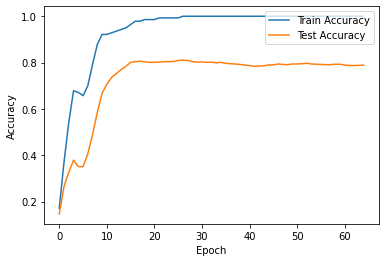

Epoch : 065, Loss : 0.04122, Train Accuracy : 1.00000, Test Accuracy : 0.78500


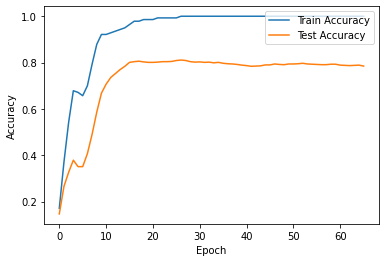

Epoch : 066, Loss : 0.04960, Train Accuracy : 1.00000, Test Accuracy : 0.78700


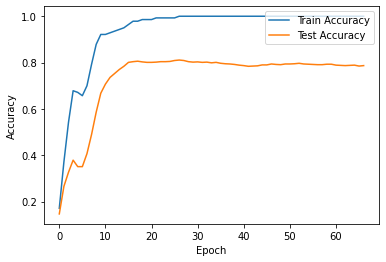

Epoch : 067, Loss : 0.04219, Train Accuracy : 1.00000, Test Accuracy : 0.78200


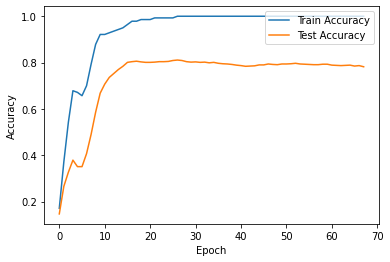

Epoch : 068, Loss : 0.04596, Train Accuracy : 1.00000, Test Accuracy : 0.78100


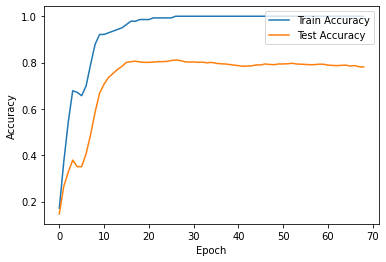

Epoch : 069, Loss : 0.06831, Train Accuracy : 1.00000, Test Accuracy : 0.78300


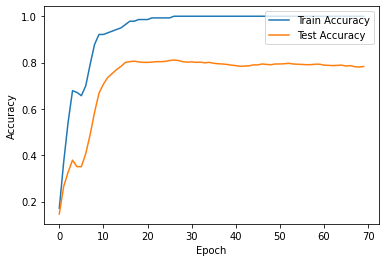

Epoch : 070, Loss : 0.04252, Train Accuracy : 1.00000, Test Accuracy : 0.78500


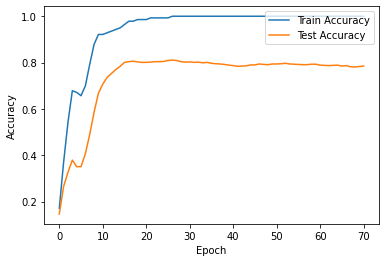

Epoch : 071, Loss : 0.05260, Train Accuracy : 1.00000, Test Accuracy : 0.78900


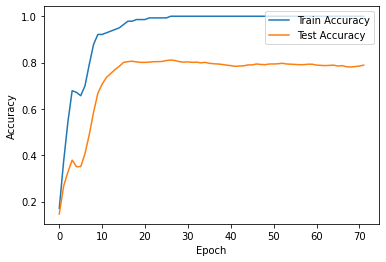

Epoch : 072, Loss : 0.04114, Train Accuracy : 1.00000, Test Accuracy : 0.78800


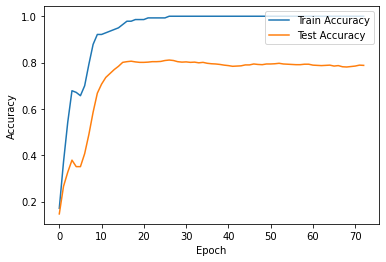

Epoch : 073, Loss : 0.07073, Train Accuracy : 1.00000, Test Accuracy : 0.78900


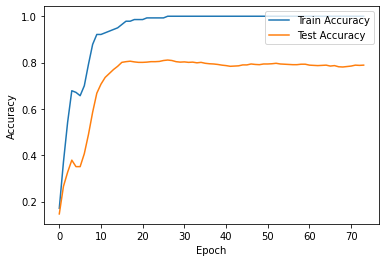

Epoch : 074, Loss : 0.04833, Train Accuracy : 1.00000, Test Accuracy : 0.79100


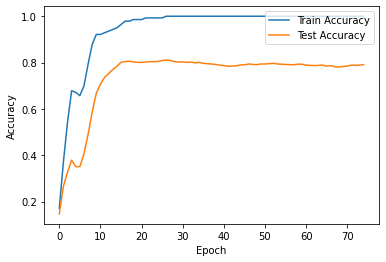

Epoch : 075, Loss : 0.04660, Train Accuracy : 1.00000, Test Accuracy : 0.79200


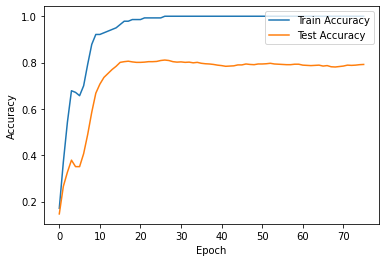

Epoch : 076, Loss : 0.04737, Train Accuracy : 1.00000, Test Accuracy : 0.79300


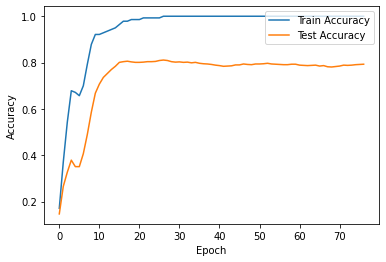

Epoch : 077, Loss : 0.03686, Train Accuracy : 1.00000, Test Accuracy : 0.79300


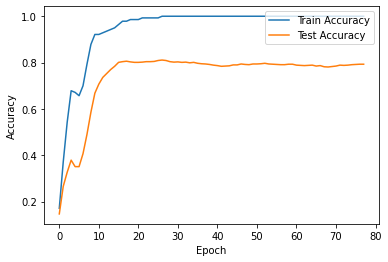

Epoch : 078, Loss : 0.05757, Train Accuracy : 1.00000, Test Accuracy : 0.79400


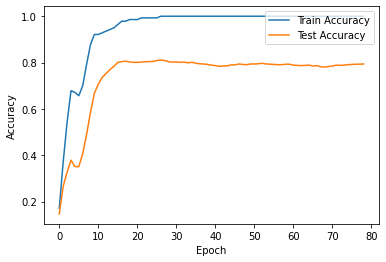

Epoch : 079, Loss : 0.03885, Train Accuracy : 1.00000, Test Accuracy : 0.79400


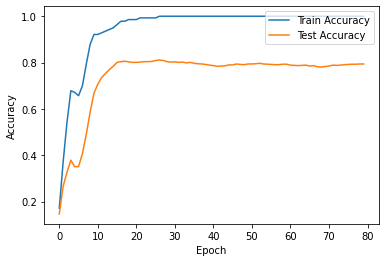

Epoch : 080, Loss : 0.03754, Train Accuracy : 1.00000, Test Accuracy : 0.79500


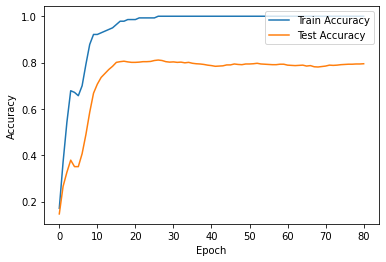

Epoch : 081, Loss : 0.04513, Train Accuracy : 1.00000, Test Accuracy : 0.79600


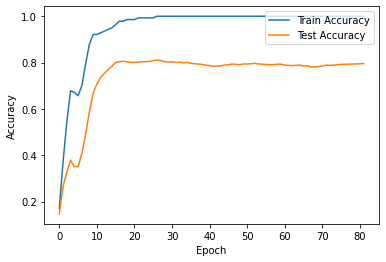

Epoch : 082, Loss : 0.05552, Train Accuracy : 1.00000, Test Accuracy : 0.79800


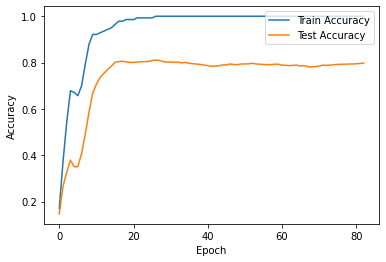

Epoch : 083, Loss : 0.03330, Train Accuracy : 1.00000, Test Accuracy : 0.80100


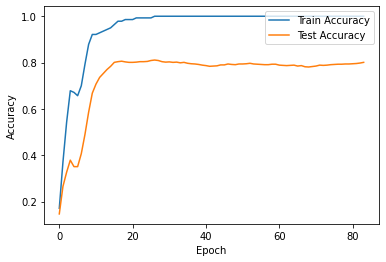

Epoch : 084, Loss : 0.05513, Train Accuracy : 1.00000, Test Accuracy : 0.80000


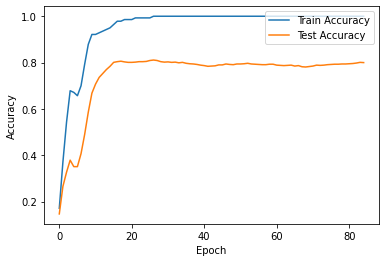

Epoch : 085, Loss : 0.04619, Train Accuracy : 1.00000, Test Accuracy : 0.79800


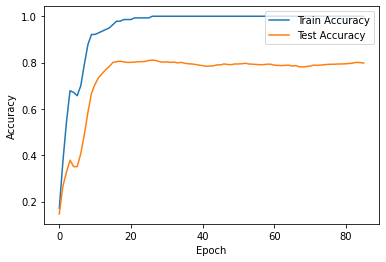

Epoch : 086, Loss : 0.05804, Train Accuracy : 1.00000, Test Accuracy : 0.79800


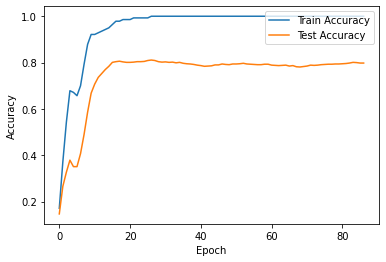

Epoch : 087, Loss : 0.05040, Train Accuracy : 1.00000, Test Accuracy : 0.79700


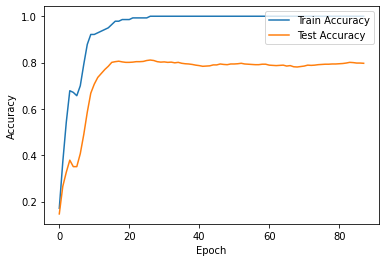

Epoch : 088, Loss : 0.03963, Train Accuracy : 1.00000, Test Accuracy : 0.79500


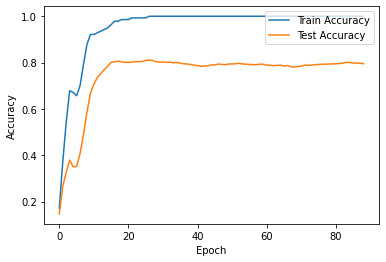

Epoch : 089, Loss : 0.03805, Train Accuracy : 1.00000, Test Accuracy : 0.79600


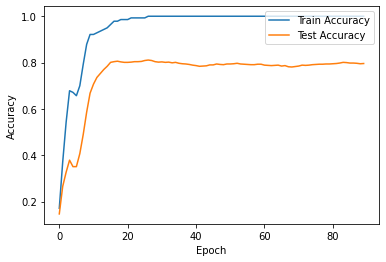

Epoch : 090, Loss : 0.05082, Train Accuracy : 1.00000, Test Accuracy : 0.79800


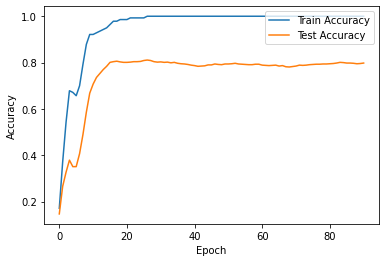

Epoch : 091, Loss : 0.07339, Train Accuracy : 1.00000, Test Accuracy : 0.79700


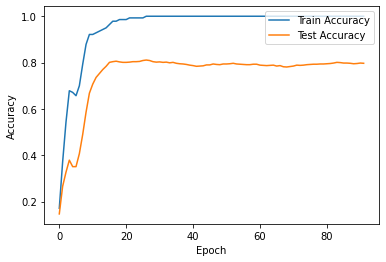

Epoch : 092, Loss : 0.04994, Train Accuracy : 1.00000, Test Accuracy : 0.79700


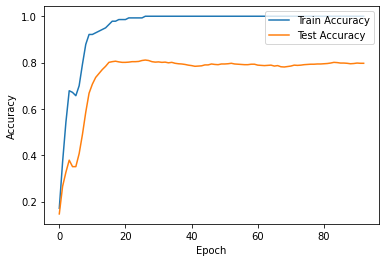

Epoch : 093, Loss : 0.05104, Train Accuracy : 1.00000, Test Accuracy : 0.79800


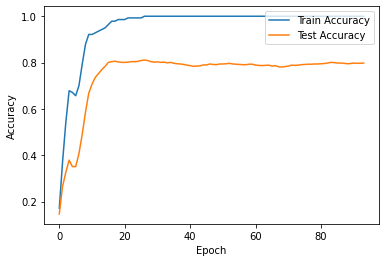

Epoch : 094, Loss : 0.04471, Train Accuracy : 1.00000, Test Accuracy : 0.79600


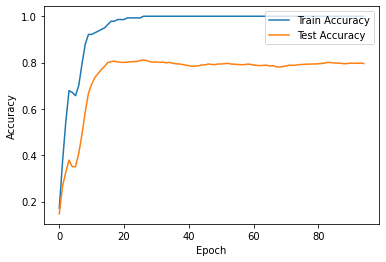

Epoch : 095, Loss : 0.04447, Train Accuracy : 1.00000, Test Accuracy : 0.79600


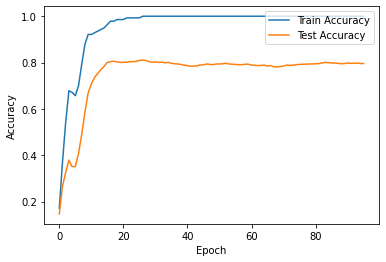

Epoch : 096, Loss : 0.05517, Train Accuracy : 1.00000, Test Accuracy : 0.79200


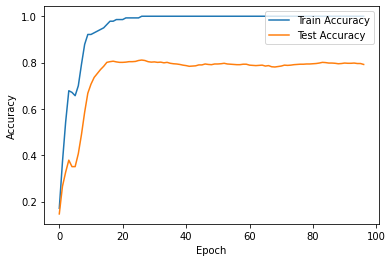

Epoch : 097, Loss : 0.04553, Train Accuracy : 1.00000, Test Accuracy : 0.79200


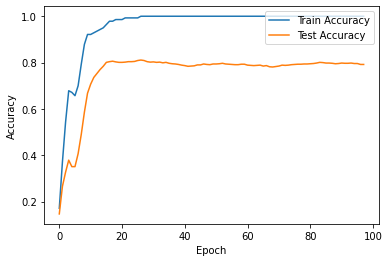

Epoch : 098, Loss : 0.04040, Train Accuracy : 1.00000, Test Accuracy : 0.79300


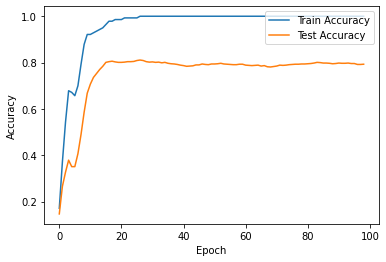

Epoch : 099, Loss : 0.04165, Train Accuracy : 1.00000, Test Accuracy : 0.79300


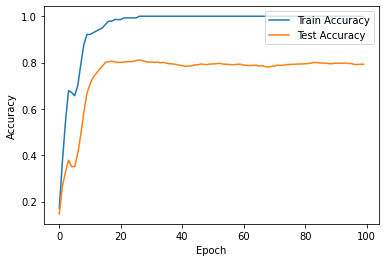

In [30]:
main()